In [ ]:
!nvidia-smi

Wed Sep 29 17:06:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install mne
!pip install braindecode

     |████████████████████████████████| 6.9 MB 4.7 MB/s 
     |████████████████████████████████| 97 kB 3.4 MB/s 
     |████████████████████████████████| 128 kB 16.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
DATA_FOLDER = "/home/data/"
OUTPUT_FOLDER = "/home/output/"

GDRIVE_DATA_FOLDER = "/gdrive/My Drive/Projects/BEETL/data/sleep/"
GDRIVE_OUTPUT_FOLDER = "/gdrive/MyDrive/Projects/BEETL/output/"

In [ ]:
!mkdir {OUTPUT_FOLDER}
!mkdir {DATA_FOLDER}
!unzip -qq {GDRIVE_DATA_FOLDER}SleepSource.zip -d {DATA_FOLDER}
!unzip -qq {GDRIVE_DATA_FOLDER}LeaderboardSleep.zip -d {DATA_FOLDER}
!unzip -qq {GDRIVE_DATA_FOLDER}finalSleep.zip -d {DATA_FOLDER}

In [ ]:
!ls {DATA_FOLDER}
!ls {DATA_FOLDER}LeaderboardSleep/
!ls {DATA_FOLDER}finalSleep/

finalSleep  LeaderboardSleep  SleepSource
sleep_target  testing
sleep_target  testing


## setup

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
SOURCE_DATA_FOLDER = DATA_FOLDER + "SleepSource/"
LEADERBOARD_TARGET_DATA_FOLDER = DATA_FOLDER + "LeaderboardSleep/sleep_target/"
LEADERBOARD_TEST_DATA_FOLDER = DATA_FOLDER + "LeaderboardSleep/testing/"
FINAL_TARGET_DATA_FOLDER = DATA_FOLDER + "finalSleep/sleep_target/"
FINAL_TEST_DATA_FOLDER = DATA_FOLDER + "finalSleep/testing/"

## data_utils

In [ ]:
import mne

In [ ]:
def load_data(data_folder, load_labels=True):
    fn_list = sorted(os.listdir(data_folder))
    print(f"Loading data from folder: {data_folder} ({len(fn_list)} files) - Load labels {load_labels}")

    data_map = {}
    subject_list = []
    sample_counter = 0

    for fn in tqdm(fn_list):
        if fn.endswith("X.npy"):
            code = fn.split("_")[1][:-4]
        elif fn == "headerInfo.npy":
            meta = np.load(data_folder + fn, allow_pickle=True)
            print(meta)
            continue
        else:
            continue

        eeg = np.load(data_folder + fn, allow_pickle=True)

        if load_labels:
            label_fn = fn.replace("X", "y")
            label = np.load(data_folder + label_fn, allow_pickle=True)
        else:
            label = None

        s_part, r_part = code.split("r")
        subject = int(s_part[1:])
        repetition = int(r_part[:-1])
        
        subject_list.append(subject)

        if subject not in data_map.keys():
            data_map[subject] = {}

        data_map[subject][repetition] = {"eeg": eeg, "label": label}
        sample_counter += len(eeg)

    subject_list = np.unique(subject_list)
    print(f"Loaded total {sample_counter} samples for subjects: {subject_list}")
    return data_map, subject_list

### preprocessing

In [ ]:
def prepare_window_data(data, subject_list=None):
    window_data = []
    window_labels = []

    if subject_list is None:
        subject_list = data.keys()

    for s in tqdm(subject_list):
        for r in data[s].keys():
            eeg = data[s][r]["eeg"]
            label = data[s][r]["label"]

            window_data.extend(eeg)
            
            if label is not None:
                window_labels.extend(label)

    return window_data, window_labels

In [ ]:
def print_stats(desc, data):
    print(f"{desc} mean: {np.mean(data)}, std: {np.std(data)}, min: {np.min(data)}, max: {np.max(data)}")

def normalize(data, mean_value, std_value, desc=""):
    data = np.array(data)
    data = (data - mean_value) / std_value
    print_stats(desc, data)
    return list(data)

## runner_utils

In [ ]:
import os
import torch
import random
import numpy as np

def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## dataset

In [ ]:
def add_noise(data):
    if np.random.rand() > 0.5:
        data += np.random.normal(0, 0.01, (data.shape))
    return data

def mixup(data, mixup_data):
    mixup_rate = np.random.rand() * 0.4
    idx = np.random.randint(0, len(mixup_data))
    return (1-mixup_rate)*data + mixup_rate*mixup_data[idx]

In [ ]:
class SleepDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None, mixup_data=None, mixup_idx=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.mixup_data = mixup_data
        self.mixup_idx = mixup_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eeg = self.data[idx]
        
        ### DATA AUGMENTATION ###
        if self.mixup_data is not None:
            if self.mixup_idx is not None:
                if self.mixup_idx[idx]:
                    eeg = mixup(eeg, self.mixup_data)
            else:
                eeg = mixup(eeg, self.mixup_data)

        if self.transform:
            eeg = self.transform(eeg)
        ### END DATA AUGMENTATION ###
        
        eeg = eeg.astype(np.float32)

        if self.labels is not None:
            label = self.labels[idx].astype(np.int64)
        else:
            label = -1

        return {"eeg": eeg, "label": label}

## runner

### Focal loss

In [ ]:
import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    """ Focal loss with optional label smoothing.

    Calculates mean focal loss over given data with optional label smoothing.

    Attributes
    ----------
        alpha: int = 1
        gamma: int = 2
        logits: bool = True
        reduce: bool = True
        ls: float = None
            label smoothing ratio, if None label smoothing will not be applied
        classes: int = None
            number of classes required for label smoothing
    """

    def __init__(
        self,
        alpha: int = 1,
        gamma: int = 2,
        logits: bool = True,
        reduce: bool = True,
        ls: float = 0.05,
        classes: int = 6,
    ):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce
        self.ls = ls
        self.classes = classes

    def forward(self, inputs, targets):
        targets = F.one_hot(targets, num_classes=6)

        if self.ls is not None:
            targets = (1 - self.ls) * targets + self.ls / self.classes

        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction="none")

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

### VAT

In [ ]:
# implementation from: https://github.com/lyakaap/VAT-pytorch

import contextlib
import torch
import torch.nn as nn
import torch.nn.functional as F


@contextlib.contextmanager
def _disable_tracking_bn_stats(model):

    def switch_attr(m):
        if hasattr(m, 'track_running_stats'):
            m.track_running_stats ^= True
            
    model.apply(switch_attr)
    yield
    model.apply(switch_attr)


def _l2_normalize(d):
    d_reshaped = d.view(d.shape[0], -1, *(1 for _ in range(d.dim() - 2)))
    d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-8
    return d


class VATLoss(nn.Module):

    def __init__(self, xi=10.0, eps=1.0, ip=1):
        """VAT loss
        :param xi: hyperparameter of VAT (default: 10.0)
        :param eps: hyperparameter of VAT (default: 1.0)
        :param ip: iteration times of computing adv noise (default: 1)
        """
        super(VATLoss, self).__init__()
        self.xi = xi
        self.eps = eps
        self.ip = ip

    def forward(self, model, x):
        with torch.no_grad():
            pred = F.softmax(model(x), dim=1)

        # prepare random unit tensor
        d = torch.rand(x.shape).sub(0.5).to(x.device)
        d = _l2_normalize(d)

        with _disable_tracking_bn_stats(model):
            # calc adversarial direction
            for _ in range(self.ip):
                d.requires_grad_()
                pred_hat = model(x + self.xi * d)
                logp_hat = F.log_softmax(pred_hat, dim=1)
                adv_distance = F.kl_div(logp_hat, pred, reduction='batchmean')
                adv_distance.backward()
                d = _l2_normalize(d.grad)
                model.zero_grad()
    
            # calc LDS
            r_adv = d * self.eps
            pred_hat = model(x + r_adv)
            logp_hat = F.log_softmax(pred_hat, dim=1)
            lds = F.kl_div(logp_hat, pred, reduction='batchmean')

        return lds

### train, validate, predict

In [ ]:
import torch
import numpy as np

def train_epoch(args, model, loader, criterion, optimizer, scheduler, epoch):
    losses = []
    targets_all = []
    outputs_all = []

    vat_loss = VATLoss(xi=10.0, eps=1.0, ip=1)

    model.train()
    t = tqdm(loader)

    for i, sample in enumerate(t):
        optimizer.zero_grad()

        eeg = sample["eeg"].to(args.device)
        target = sample["label"].to(args.device)

        lds = vat_loss(model, eeg)
        output = model(eeg)
        loss = criterion(output, target) + args.alpha * lds
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        losses.append(loss.item())
        
        target = target.cpu().numpy()
        output = output.detach().cpu().numpy()

        targets_all.extend(target)
        outputs_all.extend(output)

        output_loss = np.mean(losses)
        output_score = np.mean(targets_all == np.argmax(outputs_all, axis=1))

        t.set_description(
            f"Epoch {epoch}/{args.epochs} - Train loss: {output_loss:0.4f}, score: {output_score:0.4f}"
        )

    return targets_all, outputs_all, output_score, output_loss


def validate(args, model, loader, criterion, desc="Valid"):
    losses = []
    targets_all = []
    outputs_all = []

    t = tqdm(loader)
    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(t):
            eeg = sample["eeg"].to(args.device)
            target = sample["label"].to(args.device)

            output = model(eeg)
            loss = criterion(output, target)

            losses.append(loss.item())
            targets_all.extend(target.cpu().numpy())
            outputs_all.extend(output.detach().cpu().numpy())

            output_loss = np.mean(losses)
            output_score = np.mean(targets_all == np.argmax(outputs_all, axis=1))

            t.set_description(
                f"\t  - {desc} loss: {output_loss:0.4f}, score: {output_score:0.4f}"
            )

    return targets_all, outputs_all, output_score, output_loss


def predict(args, model, loader):
    outputs_all = []

    t = tqdm(loader)
    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(t):
            eeg = sample["eeg"].to(args.device)

            output = model(eeg)
            outputs_all.extend(output.detach().cpu().numpy())
    return outputs_all

## model

In [ ]:
import torch
import torch.nn as nn

In [ ]:
def get_linear(in_features, out_features):
    return nn.utils.weight_norm(nn.Linear(in_features, out_features))

class BaseEEGClassifier(nn.Module):
    def __init__(self):
        super(BaseEEGClassifier, self).__init__()

        N_channels = [64, 128, 256]
        
        self.c1 = nn.Sequential(nn.Conv1d(2, N_channels[0], 401, 50, 200),
                                nn.BatchNorm1d(N_channels[0]),
                                nn.SiLU(),
                                nn.Dropout(0.2),
                                nn.MaxPool1d(3,2,1),
                                nn.Conv1d(N_channels[0], N_channels[1], 7, 2, 3),
                                nn.BatchNorm1d(N_channels[1]),
                                nn.SiLU(),
                                nn.Dropout(0.2),
                                nn.Conv1d(N_channels[1], N_channels[2], 5, 1, 2),
                                nn.BatchNorm1d(N_channels[2]),
                                nn.AdaptiveMaxPool1d(1),
                                )
        
        self.c2 = nn.Sequential(nn.Conv1d(2, N_channels[0], 51, 5, 25),
                                nn.BatchNorm1d(N_channels[0]),
                                nn.SiLU(),
                                nn.Dropout(0.2),
                                nn.MaxPool1d(9,3,4),
                                nn.Conv1d(N_channels[0], N_channels[1], 7, 2, 3),
                                nn.BatchNorm1d(N_channels[1]),
                                nn.SiLU(),
                                nn.Conv1d(N_channels[1], N_channels[2], 5, 1, 2),
                                nn.BatchNorm1d(N_channels[2]),
                                nn.AdaptiveMaxPool1d(1),
                                )
        
        self.linear = get_linear(N_channels[2]*2, 1024)
        self.act = nn.SiLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x1 = self.c1(x)
        x2 = self.c2(x)

        x = torch.cat([x1, x2], dim=1)
        x = x.flatten(1,-1)
        x = self.act(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.act(x)
        return x

class EEGClassifier(nn.Module):
    def __init__(self):
        super(EEGClassifier, self).__init__()

        self.base = BaseEEGClassifier()
        self.fc = get_linear(1024, 6)

    def features(self, x):
        x = self.base(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        return x

## main

In [ ]:
import seaborn as sns
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix

### args

In [ ]:
import json

class base_args(object):
    def __init__(self, model_name, seed=42):
        self.model_name = model_name
        self.seed = seed

        self.lr = 1e-3
        self.epochs = 5
        self.batch_size = 120
        self.num_workers = 2
        self.device = ('cuda' if torch.cuda.is_available() else 'cpu')
        self.alpha = 0.01
        self.phase = "base"

    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4)

    def get_model_name(self):
        return f"{self.model_name}_{self.phase}"

### experiment helper functions

In [ ]:
def train_model(args, model, 
          train_data, train_labels, 
          valid_data, valid_labels, 
          train_weights=None, sample_rate=None, 
          use_scheduler=True,
          history = {"Train": {"Score": [], "Loss": []}, 
                     "Valid": {"Score": [], "Loss": []}},
          mixup_data=None, mixup_idx=None):
    
    train_dataset = SleepDataset(train_data, train_labels, transform=add_noise, mixup_data=mixup_data, mixup_idx=mixup_idx)
    
    if train_weights is not None:
        train_sampler = WeightedRandomSampler(weights = train_weights, num_samples=int(len(train_labels)*sample_rate))
        train_loader = DataLoader(train_dataset, num_workers=args.num_workers, batch_size=args.batch_size, sampler=train_sampler, drop_last=True)
    else:
        train_loader = DataLoader(train_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=True, drop_last=True)

    model = model.to(args.device)
    criterion = FocalLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=5e-4)

    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
                        optimizer,
                        max_lr=args.lr,
                        epochs=args.epochs,
                        steps_per_epoch=len(train_loader),
                        div_factor=10, 
                        final_div_factor=10,
                        pct_start=0.1,
                        anneal_strategy="cos",
                    )
    else:
        scheduler = None
    
    for epoch in range(1, args.epochs+1):
        _, _, train_score, train_loss = train_epoch(args, model, train_loader, criterion, optimizer, scheduler, epoch)
        _, _, valid_score, valid_loss = validate_model(args, model, valid_data, valid_labels, show_plot=False)

        history["Train"]["Loss"].append(train_loss)
        history["Train"]["Score"].append(train_score)
        history["Valid"]["Loss"].append(valid_loss)
        history["Valid"]["Score"].append(valid_score)

    torch.save(model.state_dict(), f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt")


def validate_model(args, model, valid_data, valid_labels, desc="Target", show_plot=True):
    criterion = FocalLoss()

    valid_dataset = SleepDataset(valid_data, valid_labels)
    valid_loader = DataLoader(valid_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)
    targets_all, outputs_all, output_score, output_loss = validate(args, model, valid_loader, criterion, desc)
    
    if show_plot:
        cf_mat = confusion_matrix(targets_all, np.argmax(outputs_all, axis=1), normalize="true")
        plt.figure()
        sns.heatmap(cf_mat, annot=True)
        plt.show()

    return targets_all, outputs_all, output_score, output_loss


def get_prediction(args, model, data):
    model.to(args.device)
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    
    dataset = SleepDataset(data, None)
    loader = DataLoader(dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)

    output = predict(args, model, loader)
    return output


def ensemble(args_array, dataset_name="test", phase=None):
    ensemble_output = None

    for args in args_array:
        if phase is None:
            fn = f"{OUTPUT_FOLDER}{args.get_model_name()}-{dataset_name}_output.npy"
        else:
            fn = f"{OUTPUT_FOLDER}{args.model_name}_{phase}-{dataset_name}_output.npy"
            
        output = np.load(fn)
        if ensemble_output is None:
            ensemble_output = output
        else:
            ensemble_output += output
    
    return ensemble_output
    

def predict_and_save(args, model, target_data, test_data):
    target_output = get_prediction(args, model, target_data)
    np.save(f"{OUTPUT_FOLDER}{args.get_model_name()}-target_output.npy", target_output)
    
    test_output = get_prediction(args, model, test_data)
    np.save(f"{OUTPUT_FOLDER}{args.get_model_name()}-test_output.npy", test_output)


def plot_history(history):
    fig, axes = plt.subplots(2,1, figsize=(22,6))
    axes[0].plot(history["Train"]["Score"], label="Train score")
    axes[0].plot(history["Valid"]["Score"], label="Valid score")
    axes[0].legend()
    axes[1].plot(history["Train"]["Loss"], label="Train loss")
    axes[1].plot(history["Valid"]["Loss"], label="Valid loss")
    axes[1].legend()
    fig.show()

### competition data loaders

In [ ]:
def get_phase_1_data():
    source_data, source_subjects = load_data(SOURCE_DATA_FOLDER)
    source_data, source_labels = prepare_window_data(source_data, source_subjects)
    # calculate stats of source data and normalize it
    source_data = np.array(source_data)
    source_mean = np.mean(source_data)
    source_std = np.std(source_data)
    source_data = (source_data - source_mean) / source_std
    print(f"Source mean: {source_mean}, std: {source_std}, min: {np.min(source_data)}, max: {np.max(source_data)}")
    source_data  = list(source_data)
    # load and normalize target data
    lb_target_data, lb_target_subjects = load_data(LEADERBOARD_TARGET_DATA_FOLDER)
    lb_target_data, lb_target_labels = prepare_window_data(lb_target_data, lb_target_subjects)
    lb_target_data = normalize(lb_target_data, source_mean, source_std, "Leadeboard target")
    # load and normalize test data
    lb_test_data, lb_test_subjects = load_data(LEADERBOARD_TEST_DATA_FOLDER, load_labels=False)
    lb_test_data, lb_test_labels = prepare_window_data(lb_test_data, lb_test_subjects)
    lb_test_data = normalize(lb_test_data, source_mean, source_std, "Leadeboard test")

    return source_data, source_labels, lb_target_data, lb_target_labels, lb_test_data, lb_test_data


def get_phase_2_data():
    source_data, source_subjects = load_data(SOURCE_DATA_FOLDER)
    source_data, source_labels = prepare_window_data(source_data, source_subjects)
    # add target data from phase 1 to source data
    lb_target_data, lb_target_subjects = load_data(LEADERBOARD_TARGET_DATA_FOLDER)
    lb_target_data, lb_target_labels = prepare_window_data(lb_target_data, lb_target_subjects)
    source_data += lb_target_data
    source_labels += lb_target_labels
    # calculate stats and normalize
    source_data = np.array(source_data)
    source_mean = np.mean(source_data)
    source_std = np.std(source_data)
    source_data = (source_data - source_mean) / source_std
    print(f"Source mean: {source_mean}, std: {source_std}, min: {np.min(source_data)}, max: {np.max(source_data)}")
    source_data  = list(source_data)
    # load test data from phase 1 and normalize it
    lb_test_data, lb_test_subjects = load_data(LEADERBOARD_TEST_DATA_FOLDER, load_labels=False)
    lb_test_data, lb_test_labels = prepare_window_data(lb_test_data, lb_test_subjects)
    lb_test_data = normalize(lb_test_data, source_mean, source_std, "Leadeboard test")
    # load and normalize target data
    fn_target_data, fn_target_subjects = load_data(FINAL_TARGET_DATA_FOLDER)
    fn_target_data, fn_target_labels = prepare_window_data(fn_target_data, fn_target_subjects)
    fn_target_data = normalize(fn_target_data, source_mean, source_std, "Final target")
    # load and normalize test data
    fn_test_data, fn_test_subjects = load_data(FINAL_TEST_DATA_FOLDER, load_labels=False)
    fn_test_data, fn_test_labels = prepare_window_data(fn_test_data, fn_test_subjects)
    fn_test_data = normalize(fn_test_data, source_mean, source_std, "Final test")

    return source_data, source_labels, fn_target_data, fn_target_labels, fn_test_data, lb_test_data + fn_test_data

### training pipeline function

In [ ]:
def supervised_run(args, model, train_data, train_labels, target_data, target_labels, test_data, mixup_data=None):
    print(args.toJSON())

    history = {"Train": {"Score": [], "Loss": []}, 
               "Valid": {"Score": [], "Loss": []}}

    ############################
    ### USE ONLY SOURCE DATA ###
    ############################
    args.phase = "base"

    train_model(args, model, 
                train_data, train_labels, 
                target_data, target_labels, 
                mixup_data=None,
                history=history)
    # validate
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    print("\n###### PHASE 1 FINISHED ##########")
    validate_model(args, model, target_data, target_labels, "Target")
    # make predictions and save results
    predict_and_save(args, model, target_data, test_data)


    ##############################
    ### SOURCE DATA WITH MIXUP ###
    ##############################
    args.lr = 1e-4
    args.epochs = 5
    args.phase = "mixup"

    train_model(args, model, 
                train_data, train_labels, 
                target_data, target_labels, 
                mixup_data=mixup_data,
                history=history)
    # validate
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    print("\n###### PHASE 2 FINISHED ##########")
    validate_model(args, model, target_data, target_labels, "Target")
    # make predictions and save results
    predict_and_save(args, model, target_data, test_data)

    ###############################
    ### FINETUNE ON TARGET DATA ###
    ###############################
    args.lr = 1e-4
    args.epochs = 15
    args.phase = "mixup_finetuned"
    # prepare extended train data with sampler settings
    extended_train_data = train_data + target_data
    extended_train_labels = train_labels + target_labels
    train_weights = [0.25] * len(train_labels) + [0.75] * len(target_labels)
    mixup_idx = [True] * len(train_labels) + [False] * len(target_labels)
    train_sample_rate = 0.5

    train_model(args, model, 
                extended_train_data, extended_train_labels,
                target_data, target_labels,
                train_weights = train_weights, sample_rate=train_sample_rate,
                mixup_data=mixup_data, mixup_idx=mixup_idx,
                use_scheduler=False, history=history)
    
    # validate
    model.load_state_dict(torch.load(f"{OUTPUT_FOLDER}best_model_{args.get_model_name()}.pt"))
    print("\n###### PHASE 3 FINISHED ##########")
    validate_model(args, model, target_data, target_labels, "Target")
    # make predictions and save results
    predict_and_save(args, model, target_data, test_data)
    # plot training history
    plot_history(history)

### training

In [ ]:
source_data, source_labels, target_data, target_labels, test_data, mixup_data = get_phase_1_data()

Loading data from folder: /home/data/SleepSource/ (157 files) - Load labels True


  0%|          | 0/157 [00:00<?, ?it/s]

<Info | 8 non-empty values
 bads: []
 ch_names: Fpz-Cz, Pz-Oz
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1991-09-26 15:00:00 UTC
 nchan: 2
 projs: []
 sfreq: 100.0 Hz
 subject_info: 2 items (dict)
>
Loaded total 90545 samples for subjects: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


  0%|          | 0/39 [00:00<?, ?it/s]

Source mean: -2.175762164676705e-07, std: 1.6836217270029333e-05, min: -14.7172265485441, max: 12.426637935405019
Loading data from folder: /home/data/LeaderboardSleep/sleep_target/ (25 files) - Load labels True


  0%|          | 0/25 [00:00<?, ?it/s]

<Info | 8 non-empty values
 bads: []
 ch_names: Fpz-Cz, Pz-Oz
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1990-03-13 15:09:00 UTC
 nchan: 2
 projs: []
 sfreq: 100.0 Hz
 subject_info: 2 items (dict)
>
Loaded total 15442 samples for subjects: [0 1 2 3 4 5]


  0%|          | 0/6 [00:00<?, ?it/s]

Leadeboard target mean: 0.038902552623313796, std: 1.0560441229752748, min: -11.688042547053058, max: 12.010867582259191
Loading data from folder: /home/data/LeaderboardSleep/testing/ (24 files) - Load labels False


  0%|          | 0/24 [00:00<?, ?it/s]

Loaded total 25748 samples for subjects: [ 6  7  8  9 10 11 12 13 14 15 16 17]


  0%|          | 0/12 [00:00<?, ?it/s]

Leadeboard test mean: 0.014119353426048422, std: 0.8645048345254686, min: -11.985021370728651, max: 11.832680288053835


{
    "alpha": 0.01,
    "batch_size": 120,
    "device": "cuda",
    "epochs": 5,
    "lr": 0.001,
    "model_name": "eeg-classifier_seed-42",
    "num_workers": 2,
    "phase": "base",
    "seed": 42
}


  0%|          | 0/754 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]


###### PHASE 1 FINISHED ##########


  0%|          | 0/129 [00:00<?, ?it/s]

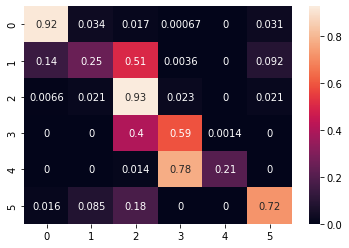

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]


###### PHASE 2 FINISHED ##########


  0%|          | 0/129 [00:00<?, ?it/s]

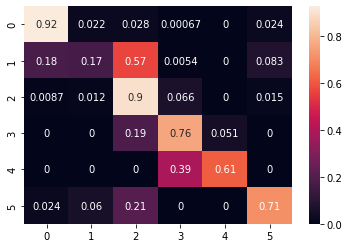

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]


###### PHASE 3 FINISHED ##########


  0%|          | 0/129 [00:00<?, ?it/s]

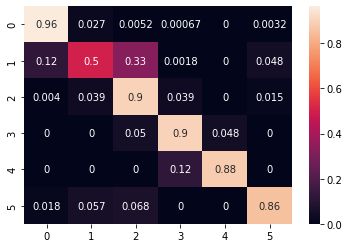

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

{
    "alpha": 0.01,
    "batch_size": 120,
    "device": "cuda",
    "epochs": 5,
    "lr": 0.001,
    "model_name": "eeg-classifier_seed-2021",
    "num_workers": 2,
    "phase": "base",
    "seed": 2021
}


  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]


###### PHASE 1 FINISHED ##########


  0%|          | 0/129 [00:00<?, ?it/s]

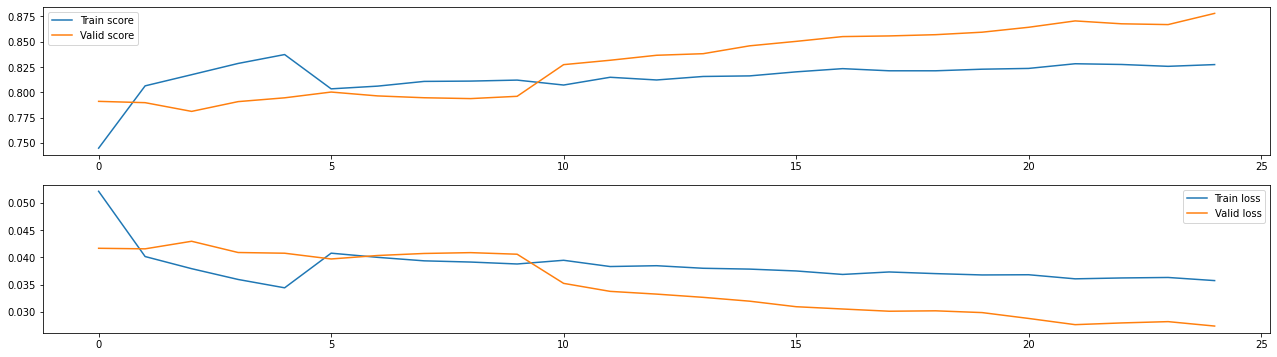

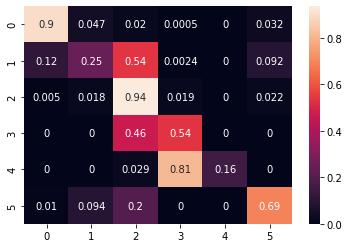

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/754 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]


###### PHASE 2 FINISHED ##########


  0%|          | 0/129 [00:00<?, ?it/s]

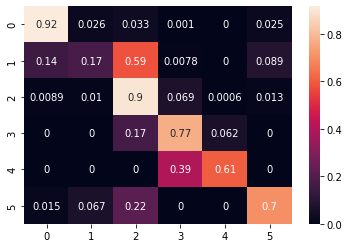

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]


###### PHASE 3 FINISHED ##########


  0%|          | 0/129 [00:00<?, ?it/s]

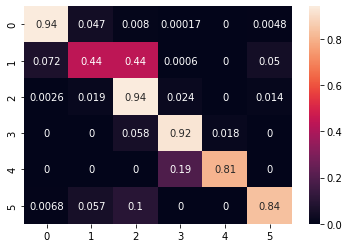

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/215 [00:00<?, ?it/s]

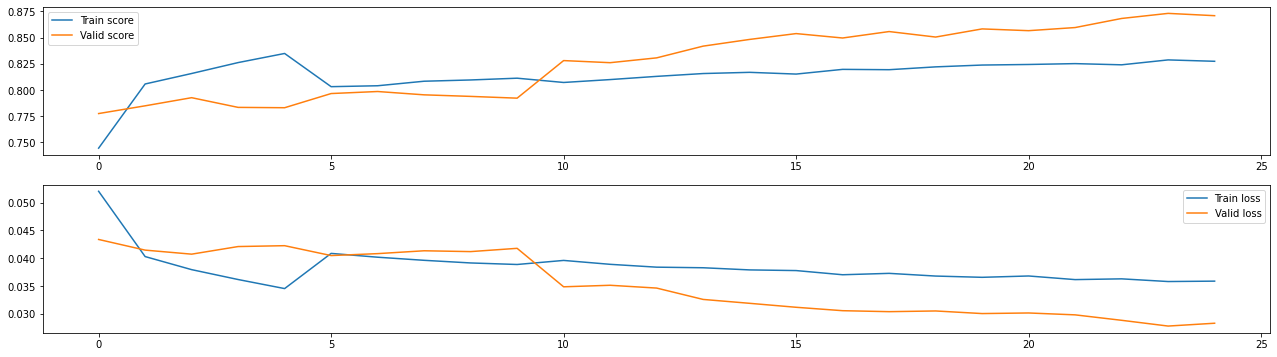

In [ ]:
args_array = []
args = base_args("eeg-classifier_seed-42")
seed_everything(args.seed)
model = EEGClassifier()
supervised_run(args, model, source_data, source_labels, target_data, target_labels, test_data, mixup_data=mixup_data)
args_array.append(args)


args = base_args("eeg-classifier_seed-2021", seed=2021)
seed_everything(args.seed)
model = EEGClassifier()
supervised_run(args, model, source_data, source_labels, target_data, target_labels, test_data, mixup_data=mixup_data)
args_array.append(args)

### ensemble predictions 

In [ ]:
target_output = ensemble(args_array, "target", "base")
target_pred = np.argmax(target_output, axis=1)
print("Base model ensemble target accuracy: ", np.mean(target_pred == target_labels))

target_output = ensemble(args_array, "target", "mixup")
target_pred = np.argmax(target_output, axis=1)
print("Mixup model ensemble target accuracy: ", np.mean(target_pred == target_labels))

test_output = ensemble(args_array, "test")
test_pred = np.argmax(test_output, axis=1)
np.savetxt(f"{OUTPUT_FOLDER}answer.txt", test_pred, delimiter=',',fmt="%d")

Base model ensemble target accuracy:  0.7903121357337133
Mixup model ensemble target accuracy:  0.7945861934982515


### save results

In [ ]:
import datetime
from google.colab import files

In [ ]:
archive_folder = f"{datetime.datetime.now():%Y-%m-%d-%H-%M}-sleep-mixup_vat_v2"
print(archive_folder)

2021-09-29-18-58-sleep-mixup_vat_v2


In [ ]:
files.download(f"{OUTPUT_FOLDER}answer.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%notebook -e {OUTPUT_FOLDER}notebook_run.ipynb

In [ ]:
!cp -R {OUTPUT_FOLDER} {GDRIVE_OUTPUT_FOLDER}{archive_folder}